In [124]:
# Code imports
from lib.opt_types import *
from lib.utils import *

# Image inpainting with proximal methods - 30 points

Image in-painting consists of reconstructing the missing parts of an image from a given incomplete image.

By exploiting some prior knowledge on the image, it is possible to in-paint images that have a large portion of their pixels missing. In this part of the homework, we are going to study different methods to achieve this goal.

We consider a subsampled image $\mathbf{b} = \mathbf{P}_{\Omega} \mathbf{x}$, where $\mathbf{P}_{\Omega} \in \mathbb{R}^{n \times p}$ is an operator that selects only few, $n \ll p := m^2$, pixels from the vectorized image $\mathbf{x} \in \mathbb{R}^p$. Our goal is to reconstruct the original image $\mathbf{x}$.

### Prior knowledge

Image inpainting is impossible without having some prior knowledge on the structure of the true image $\mathbf{x}$. 

We will explore and compare the following prior assumptions we can make on the true image: 
>  **Assumption**: There exists a orthonormal basis $\mathbf{W} \in \mathbb{R}^{p\times p}$ such that $\mathbf{x}$ can be sparsely represented in that basis, i.e, $\mathbf{W} \mathbf{x}$ is a vector with few non-zero coefficients. Said more formally, this assumption states that there exists $\mathbf{\alpha} \in \mathbb{R}^p$ with small $\ell_1$ norm such that $\mathbf{x} = \mathbf{W}^\top\alpha$. We assume that this basis is known and corresponds to the _wavelet basis_. Under this assumption, the reconstruction problem corresponds to solving the following optimization problem:
$$
    \min_{\mathbf{\alpha} \in \mathbb{R}^{p}} \underbrace{ \frac{1}{2}\|\mathbf{b} - \mathbf{P}_{\Omega} \mathbf{W}^T\mathbf{\alpha} \|_2^2}_{f_{\ell_1}(\mathbf{\alpha})} + \underbrace{\lambda_{\ell_1} \|\mathbf{\alpha}\|_1}_{g_{\ell_1}(\mathbf{\alpha})},
$$
where $\lambda_{\ell_1}$ is a coefficient we will need to choose.



# PART 1: Optimizing with an $\ell_1$ norm regularization

The optimization problem we are looking to solve have an objective function of the form:
$$
	 f(\mathbf{x}) + g(\mathbf{x}).
$$

These types of objectives are referred to as _composite objectives_ where one term, $f$, is smooth and differentiable and the other term $g$ is non-differentiable.

---

## Code structure:

Recall that we have been working with the `Function` type so far. We will augment this type to represent functions that are not differentiable:

- Given a `Function` `g` you can obtain a subgradient at a point `x` by calling `g.subgrad(x)`.

Moreover, since we are dealing with _composite_ problems with a an objective function that can be written `f + lambda*g`, we define the `CompositeFunction` type defined as
```python
@dataclass
class CompositeFunction:
    f: Function
    g: Function
```

The iterative schemes you will implement will receive a composite function that they can unpack as follows:

```python
def state_update(composite_function, state):
    f, g = composite_function

```

#### Question 1: (5 point)

A first approach to solve a non-smooth optimization problem can be to turn to subgradients. Review slide 42-44 of Lecture 6, and implement `SubG` with $\alpha_k = \frac{0.1}{\sqrt{k}}$.

In [125]:
@dataclass
class SubG_state(OptState):
    x_k: Vector
    k: int  # iteration counter (starts at 1)

In [126]:
from math import sqrt

def SubG_update(composite_function, state):
    f, g = composite_function

    # step size α_k
    alpha_k = 0.1 / sqrt(max(state.k, 1))

    # total (sub)gradient of f + g
    grad_f = f.grad(state.x_k)
    subgrad_g = g.subgrad(state.x_k)
    direction = grad_f + subgrad_g

    # update
    x_next = state.x_k - alpha_k * direction

    # advance iteration
    return SubG_state(x_k=x_next, k=state.k + 1)

def SubG_initialize(composite_function, x_zero):
    return SubG_state(x_k=x_zero, k=1)


In [127]:
SubG = OptAlgorithm(name="SubG", init_state=SubG_initialize, state_update=SubG_update)

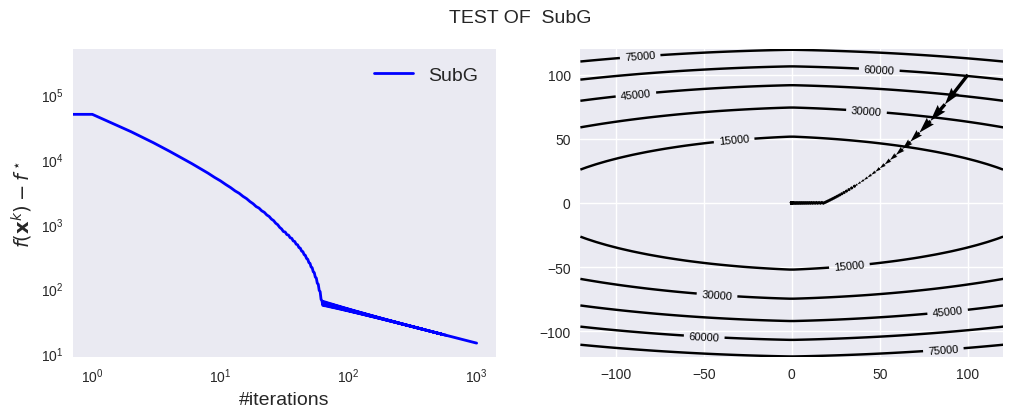

In [128]:
test_composite(SubG)


---

Another, more efficient approach, as we saw in Lecture 7, is to minimize such a function by using proximal gradient algorithms, provided that $g$ is _proximable_ (i.e., its proximal operator is efficient to evaluate). We recall the proximal operator of $g$ as the solution to the following convex problem:
$$
\mathrm{prox}_g(\mathbf{z}) := \mathrm{arg}\min_{\mathbf{y}\in\mathbb{R}^d}\{ g(\mathbf{y}) + \frac{1}{2}\Vert\mathbf{y} - \mathbf{z}\Vert_2^2\}.
$$

#### Question 2 (2 points)

Given $g_{\ell_1}: \mathbb{R}^p \rightarrow \mathbb{R}, \; g_{\ell_1}(\mathbf{x}) :=  \|\mathbf{x}\|_1$,  show that its proximal function can be written as
    $$
    \mathrm{prox}_{\gamma g_{\ell_1}}(\mathbf{z}) = \max(|\mathbf{z}|-\gamma,0) \circ \mathrm{sign}(\mathbf{z}), \; \text{for any }\mathbf{z} \in \mathbb{R}^p,\; \gamma \in \mathbb{R}_+
    $$
			where the operators $\max$, $\mathrm{sign}$ and $\lvert \cdot \lvert$ are applied coordinate-wise to the vector $\mathbf{z}$ and $\circ$ stands for $(\mathbf{x} \circ \mathbf{y})_i = x_i y_i$. Such a regularizer imposes sparsity on the solutions.


### Prox of the $\ell_1$ norm is soft–thresholding

We want
$$
\operatorname{prox}_{\gamma \|\cdot\|_1}(\mathbf{z})
\;=\;
\arg\min_{\mathbf{y}\in\mathbb{R}^p}
\;\gamma\|\mathbf{y}\|_1 + \tfrac{1}{2}\|\mathbf{y}-\mathbf{z}\|_2^2,
\qquad \gamma\ge 0.
$$

The objective is **separable** across coordinates, so the minimizer $\mathbf{y}^\star$ is obtained by solving, for each $i$,
$$
y_i^\star \;=\; \arg\min_{y\in\mathbb{R}}
\;\gamma |y| + \tfrac{1}{2}(y-z_i)^2 .
$$

This is a $1$-D convex problem. The optimality condition (subgradient $=0$) is
$$
0 \in \gamma\,\partial |y_i^\star| + (y_i^\star - z_i)
\quad\Longleftrightarrow\quad
z_i - y_i^\star \in \gamma\,\partial |y_i^\star|.
$$

Using
$$
\partial |t| \;=\;
\begin{cases}
\{1\}, & t>0,\\[2pt]
[-1,1], & t=0,\\[2pt]
\{-1\}, & t<0,
\end{cases}
$$
we solve by cases:

- If $y_i^\star>0$: then $\partial|y_i^\star|=\{1\}$ and $z_i-y_i^\star=\gamma$,
  so $y_i^\star=z_i-\gamma$, valid when $z_i>\gamma$.

- If $y_i^\star<0$: then $\partial|y_i^\star|=\{-1\}$ and $z_i-y_i^\star=-\gamma$,
  so $y_i^\star=z_i+\gamma$, valid when $z_i<-\gamma$.

- If $y_i^\star=0$: need $z_i\in \gamma[-1,1]$, i.e., $|z_i|\le \gamma$.

Combining the three cases,
$$
y_i^\star \;=\; \operatorname{sign}(z_i)\,\max\!\big(|z_i|-\gamma,\,0\big),
\qquad \text{with } \operatorname{sign}(0)=0.
$$

Vectorizing coordinate-wise (Hadamard product $\circ$), the proximal operator is
$$
\boxed{\;
\operatorname{prox}_{\gamma \|\cdot\|_1}(\mathbf{z})
\;=\; \max\!\big(|\mathbf{z}|-\gamma,\,0\big)\;\circ\; \operatorname{sign}(\mathbf{z})
\;}
$$

(the max, absolute value, sign, and Hadamard product are applied elementwise).  
This is the standard **soft-thresholding** operator, which induces sparsity.


#### Question 3 (1 point)
 Fill in the function `l1_prox` with the proximal operator of $g_{\ell_1}$.

In [129]:
def l1_prox(gamma, z):
    z = np.asarray(z)
    return np.sign(z) * np.maximum(np.abs(z) - gamma, 0.0)

#### Question 4 (4 points)

From here on, in order to speed-up the convergence of the optimization, let's assume that the function $f$ has been made to be $\mu$-strongly convex by the addition of an $\ell_2$ regularization term to the function $f$, while the $\ell_1$ term, $g$, has remained unchanged. As such, we must now utilize the strong-convexity versions of the composite optimization algorithms.

Using the information in Lecture 7 slide 21 fill in the codes of the method ISTA$_{\mu}$.

In [130]:
@dataclass
class ISTA_state(OptState):
    x_k: Vector           # current iterate
    alpha: float          # fixed step size 2/(L_f + mu)

In [131]:
def ISTA_initialize(composite_function: CompositeFunction, x_zero: Vector) -> ISTA_state:
    L = composite_function.f.lips_grad
    mu = composite_function.f.strng_cvx if composite_function.f.strng_cvx is not None else 0.0
    if L is None:
        raise ValueError("CompositeFunction.f.lips_grad must be set for ISTA_μ.")
    alpha = 2.0 / (L + mu)  # strongly-convex ISTA step size
    return ISTA_state(x_k=x_zero, alpha=alpha)

def ISTA_update(composite_function: CompositeFunction, state: ISTA_state) -> ISTA_state:
    x = state.x_k
    # gradient of the smooth part
    grad = composite_function.f.grad(x)
    # gradient step
    y = x - state.alpha * grad
    
    x_next = composite_function.g.prox(state.alpha, y)
    return ISTA_state(x_k=x_next, alpha=state.alpha)

In [132]:
ISTA = OptAlgorithm(name="ISTA", init_state= ISTA_initialize, state_update=ISTA_update)

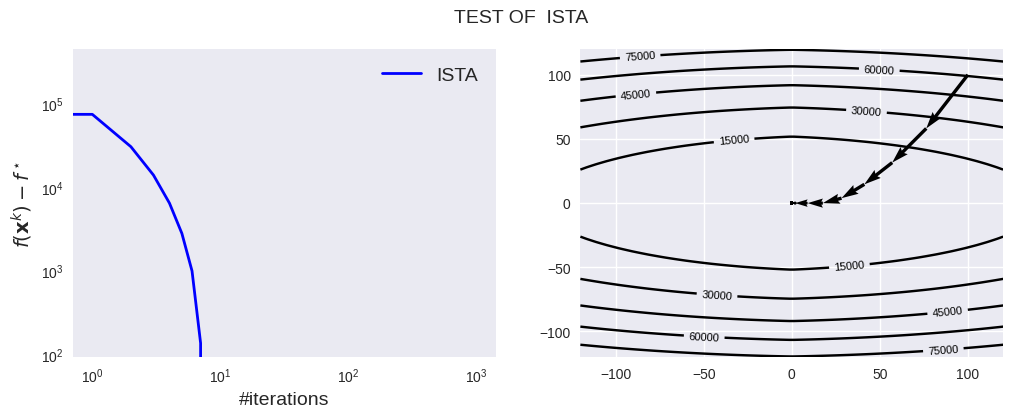

In [133]:
test_composite(ISTA)

#### Question 5  (7 points)

Using the information in Lecture 7 slide 21 fill in the codes of the method FISTA$_{\mu}$.

In [134]:
@dataclass
class FISTA_state(OptState):
    x_k: Vector          # current iterate
    x_km1: Vector        # previous iterate
    alpha: float         # stepsize (1 / L)
    beta: float          # momentum parameter based on μ and L

In [135]:
import numpy as np

def FISTA_initialize(composite_function: CompositeFunction, x_zero: Vector) -> FISTA_state:
    L = composite_function.f.lips_grad
    if L is None:
        raise ValueError("CompositeFunction.f.lips_grad must be set for FISTA_μ.")
    mu = composite_function.f.strng_cvx or 0.0

    alpha = 1.0 / L
    if mu > 0.0:
        beta = (np.sqrt(L) - np.sqrt(mu)) / (np.sqrt(L) + np.sqrt(mu))
    else:
        beta = 0.0

    # start with x_{-1} = x_0 so that the first momentum step is zero
    return FISTA_state(x_k=x_zero, x_km1=x_zero.copy(), alpha=alpha, beta=beta)

def FISTA_update(composite_function: CompositeFunction, state: FISTA_state) -> FISTA_state:
    xk, xkm1, alpha, beta = state.x_k, state.x_km1, state.alpha, state.beta

    # Extrapolation (Nesterov momentum for strongly convex case)
    yk = xk + beta * (xk - xkm1)

    # Proximal gradient step at y_k
    grad = composite_function.f.grad(yk)
    x_next = composite_function.g.prox(alpha, yk - alpha * grad)  # prox(gamma, x)

    return FISTA_state(x_k=x_next, x_km1=xk, alpha=alpha, beta=beta)

In [136]:
FISTA = OptAlgorithm(name="FISTA", init_state= FISTA_initialize, state_update=FISTA_update)

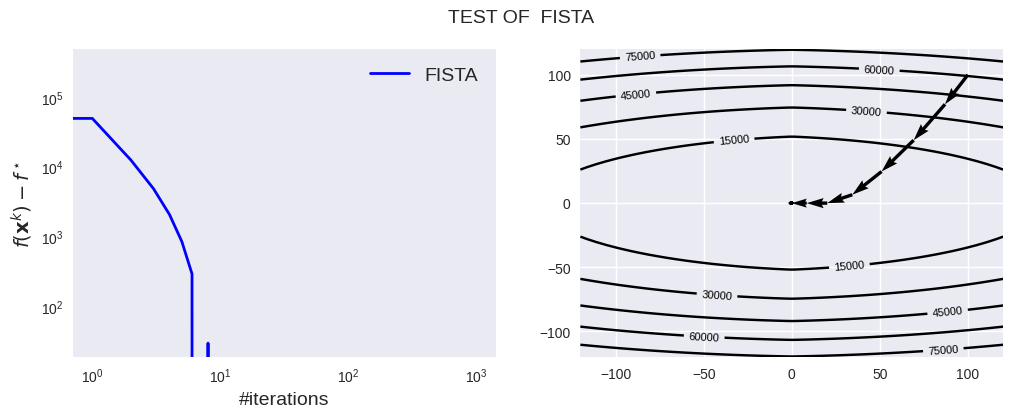

In [137]:
test_composite(FISTA)

#### Question 6  (2 points)

Compare the convergence rates of the three methods and analyze whether the observed results align with their theoretical bounds.

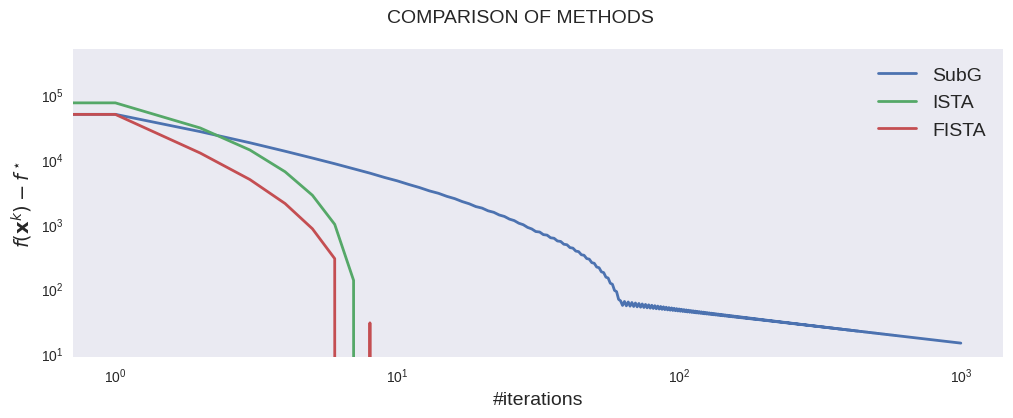

In [138]:
list_of_methods = [SubG, ISTA, FISTA]
compare_composite(list_of_methods)

- **SubG (subgradient):** Theoretical rate $O(1/\sqrt{k})$ (sublinear). On a log–log plot it decreases almost linearly with slope $-1/2$, exactly what $k^{-1/2}$ predicts.

- **ISTA$_\mu$ (prox-gradient):** For $\mu$-strongly convex $f$ with step $\alpha=\tfrac{2}{L+\mu}$, the rate is **linear**:
  $$
  f(x^k)-f^\star \;\le\; C\,(1-\mu/L)^k \;\approx\; C\,e^{-k/\kappa},\qquad \kappa=\tfrac{L}{\mu}.
  $$
  The curve drops much faster than SubG and shows the characteristic near-exponential decay, matching theory.

- **FISTA$_\mu$ (accelerated):** With momentum $\beta=\dfrac{\sqrt{L}-\sqrt{\mu}}{\sqrt{L}+\sqrt{\mu}}$, the rate is **accelerated linear**:
  $$
  f(x^k)-f^\star
  \;\le\;
  C\!\left(\frac{\sqrt{\kappa}-1}{\sqrt{\kappa}+1}\right)^{2k}
  \;=\; C\,e^{-2k/\sqrt{\kappa}},\qquad \kappa=\tfrac{L}{\mu},
  $$
  which is faster than ISTA’s $\;e^{-k/\kappa}$. In practice FISTA reaches low error in just a few iterations.

**Conclusion:** Empirical behavior aligns with the bounds: SubG $\ll$ ISTA $<$ FISTA in convergence speed; SubG is **sublinear**, ISTA is **linear**, and FISTA is **accelerated linear**.


# Part 2: Application


We have now implemented multiple methods that can solve composite optimization problems. We will now apply them to an image inpainting problem.


Take a natural image, or better a picture of you, and place it in the same directory as this notebook.

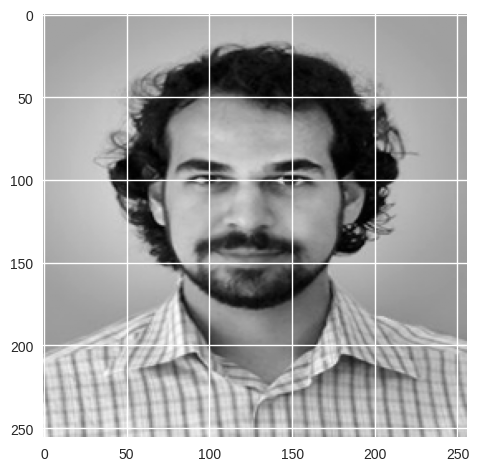

In [139]:
from lib.inpainting import *

image = load("lib/alp.jpg") #FILL IN FILE NAME

With this image in hand, let us subsample it and try to reconstruct the original.

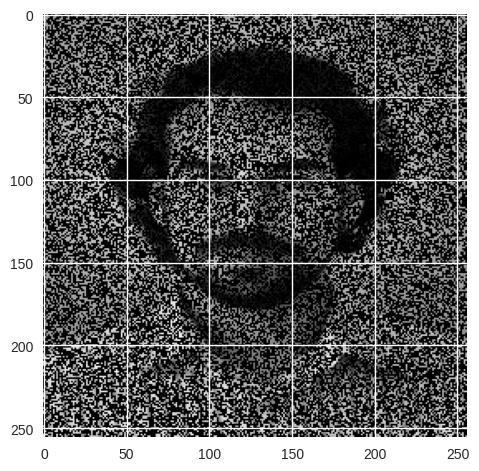

In [140]:
subsampled = show_subsampled(image)

For the rest of the questions, to ensure the function is 
$\mu$-strongly convex, we need to add an $\ell_2$ regularization term to it. As a result, we change the definition of $f_{\ell_1}(\mathbf{\alpha})$ as follows:
$$
    f_{\ell_1}(\mathbf{\alpha}) = \frac{1}{2}\|\mathbf{b} - \mathbf{P}_{\Omega} \mathbf{W}^T\mathbf{\alpha} \|_2^2 + \frac{1}{2}\mu \|\mathbf{\alpha}\|_2^2 
    $$

and the composite function becomes:
 $$
    \min_{\mathbf{\alpha} \in \mathbb{R}^{p}} \underbrace{ \frac{1}{2}\|\mathbf{b} - \mathbf{P}_{\Omega} \mathbf{W}^T\mathbf{\alpha} \|_2^2 + \frac{1}{2}\mu \|\mathbf{\alpha}\|_2^2 }_{f_{\ell_1}(\mathbf{\alpha})} + \underbrace{\lambda_{\ell_1} \|\mathbf{\alpha}\|_1}_{g_{\ell_1}(\mathbf{\alpha})},
    $$

By adding this regularization, we ensure better properties for optimization, making the solution more stable and well-behaved.

In the following cells we will define the optimization problems we need to solve to perform the reconstruction.

- We provide you with a function `P` that acts like the matrix $\mathbf{P}_{\Omega}$. That is, given a vector `x`, it returns a subsampled vector `P(x)` that corresponds to $\mathbf{P}_{\Omega} \mathbf{x}$. We also give you `P_T` which acts like $\mathbf{P}^\top$.
- We provide you with a function `W` and `W_T` that act like the matrix $\mathbf{W}$ and $\mathbf{W^\top}$ respectively. That is, for a vector `x`, `W(x)` and `W_T(x)` return $\mathbf{W}\mathbf{x}$ and $\mathbf{W^\top}\mathbf{x}$ respectively.

__(a)__ (1 point) Using these provided functions, define the observed variable `b` in the cell below.

In [141]:
from lib.inpainting import P, P_T, W, W_T

# Flatten the image and form the observed (subsampled) measurements
x = image.reshape(-1)        # flattened image
b = P(x)                     # observed vector: apply sampling operator


__(b)__ (1 point) Now define the function `f_l1` as described earlier in the problem text.

In [142]:
mu = 1e-4  # desired strong convexity of f

def f_l1(alpha):
    r = b - P(W_T(alpha))              # residual in measurement space
    return 0.5 * np.dot(r, r) + 0.5 * mu * np.dot(alpha, alpha)

__(c)__ (1 point) Write the gradient of $f_{\ell_1}(\mathbf{\alpha})$.

In [143]:
def grad_f_l1(alpha):
    r = P(W_T(alpha)) - b              # same residual but with opposite sign
    return W(P_T(r)) + mu * alpha

__(d)__ (1 points) Find the Lipschitz constant of $\nabla_\mathbf{\alpha} f_{\ell_1}(\mathbf{\alpha})$ analytically and fill it in the cell below. 

In [ ]:
# f(α) = 1/2‖b − P W^T α‖² + (μ/2)‖α‖²  ⇒  ∇f(α) = (AᵀA + μI)α − Aᵀb with A = P W^T
# Since P is a projection (‖P‖=1) and W, W^T are orthonormal (‖W‖=‖W^T‖=1),
# ‖A‖ = 1  ⇒  λ_max(AᵀA) = ‖A‖² = 1. Hence L = 1 + μ.
lips_grad_f_l1 = 1.0 + mu

We have all the necessary ingredients to define the smooth part of our composite objective:

In [145]:
f_l1 = Function(f = f_l1, grad=grad_f_l1, lips_grad = lips_grad_f_l1, strng_cvx=mu)

For the non-smooth term, we define a regularizer built around the `l1` function that re-uses the `l1_prox` function you implemented earlier:

In [146]:
l1 = Function(f = lambda x: np.sum(np.abs(x), axis=0), prox=l1_prox)

g_l1 = Regularizer(l1)

In [147]:
composite_objective = CompositeFunction(f=f_l1, g=g_l1)

With the objective defined, we provide you with a function with the following signature:
```python
solve_composite(method: OptAlgorithm, composite_objective: CompositeFunction, lmda: float, max_iterations: int) -> Vector
```

In other words, the function takes an optimization algorithm `method`, a CompositeFunction `composite_objective`, a regularization parameter `lmda` and a number of iterations `max_iterations` and returns a vector which is the last iterate given by the `method`.



In [148]:
from lib.inpainting import solve_composite

__(e)__ (5 points) Using `solve_composite` reconstruct the subsampled image. Recall that the composite problem solves for $\mathbf{\alpha}$ so you need to convert the output back to an image and visualize it.

Select a reasonable value for `lmda` or (BONUS) using the function `solve_composite` and the `PSNR` metric, find the best value for `lmda`.

Best PSNR=26.35dB at λ=0.2


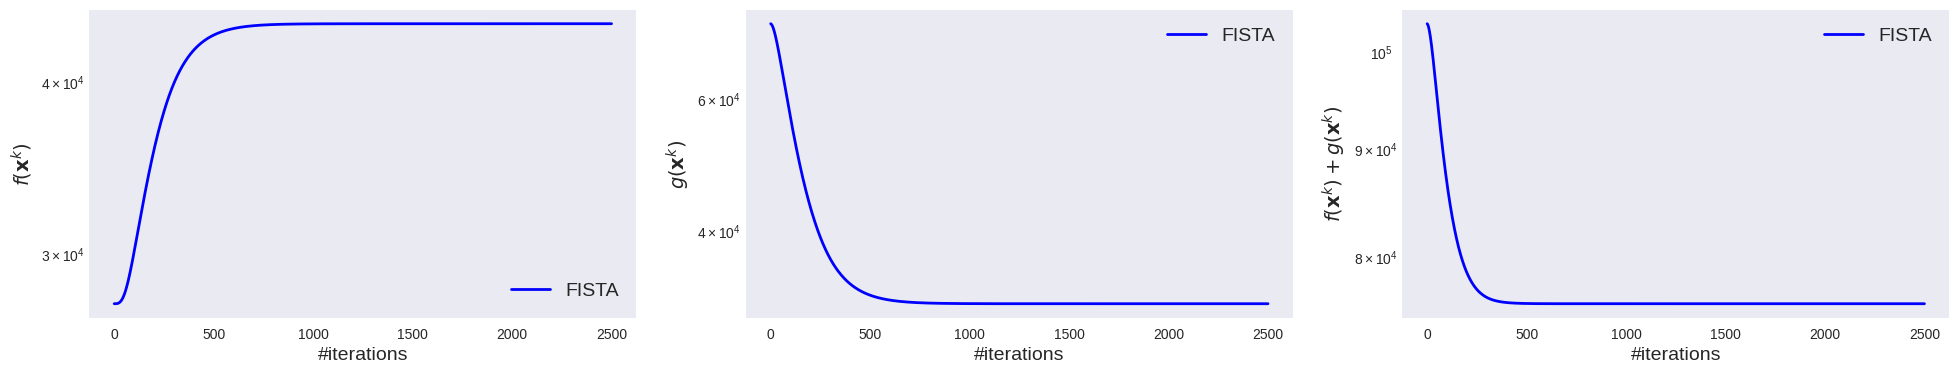

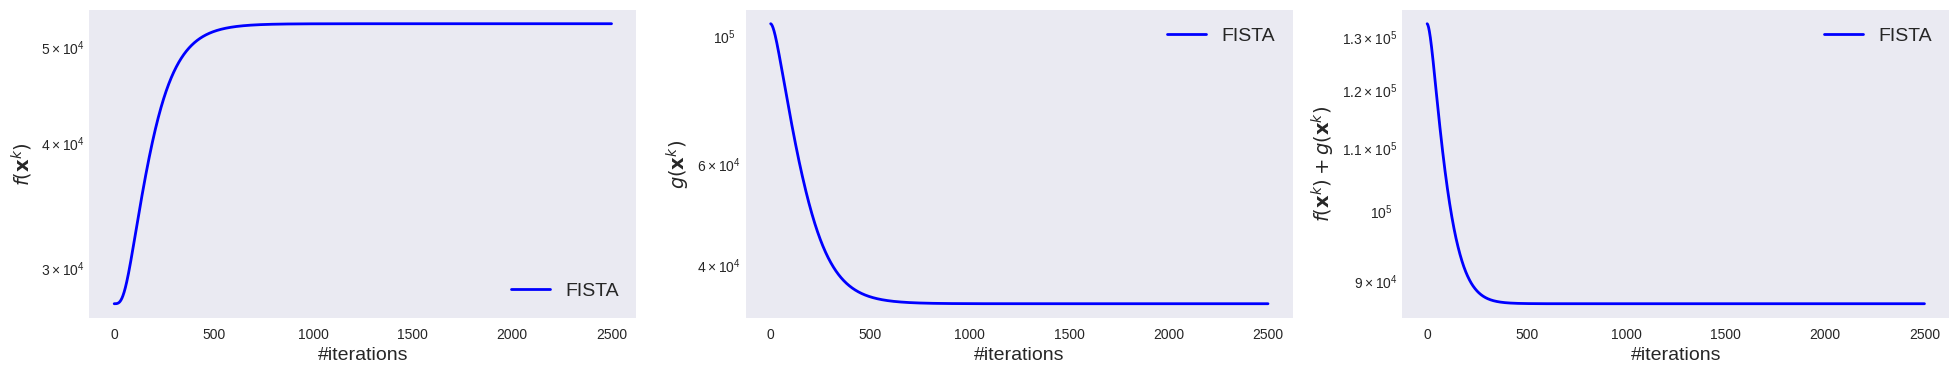

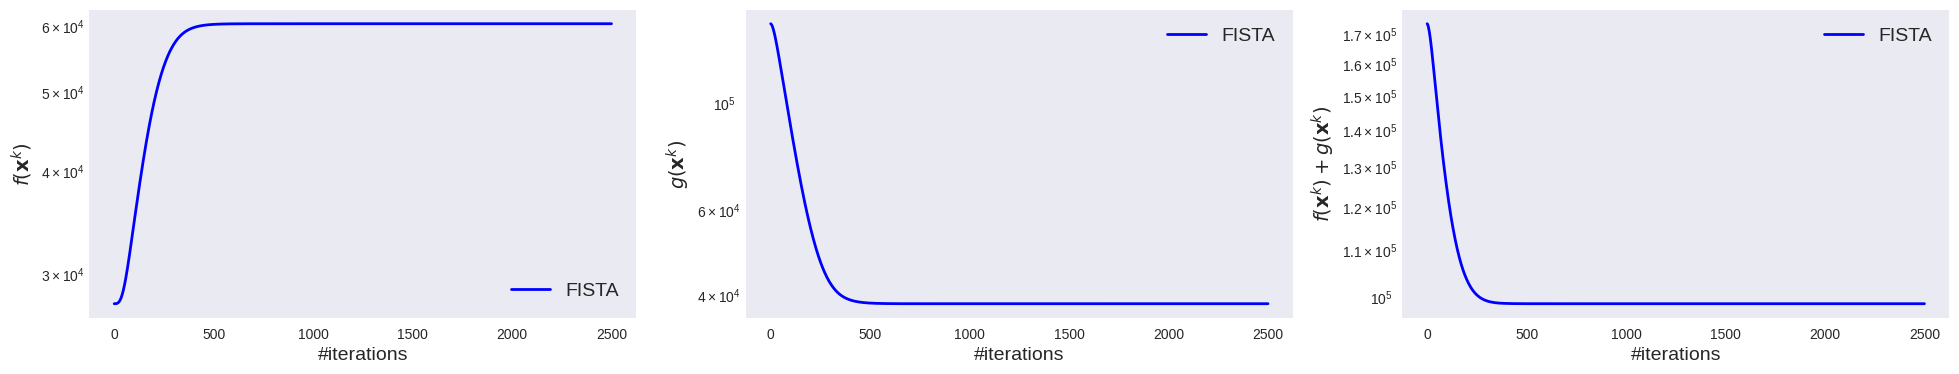

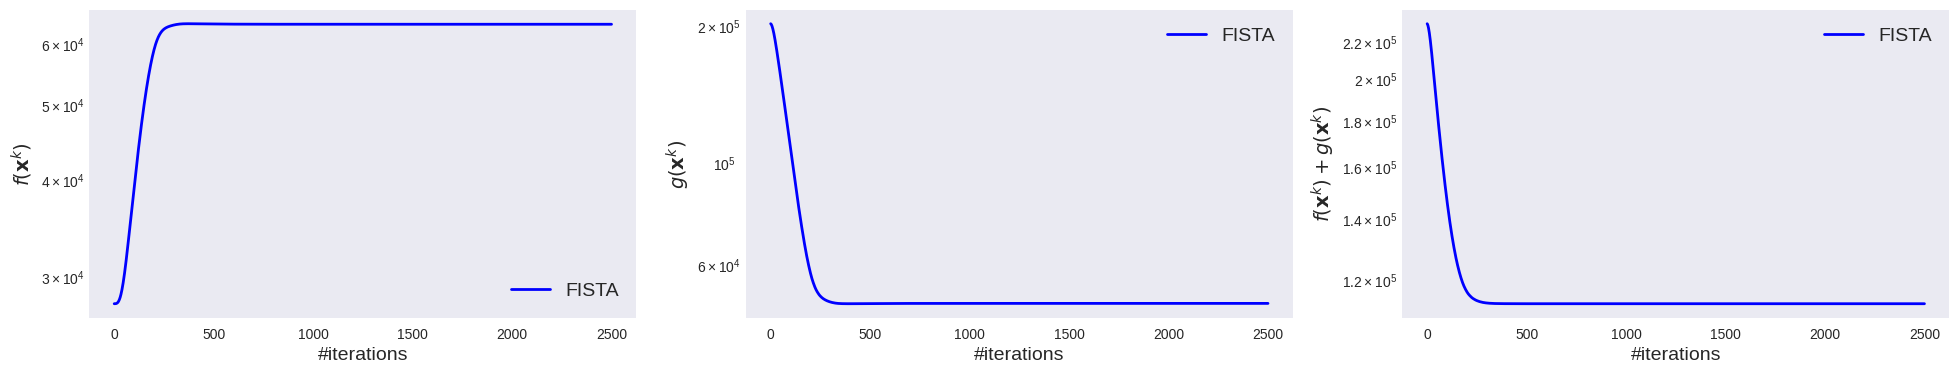

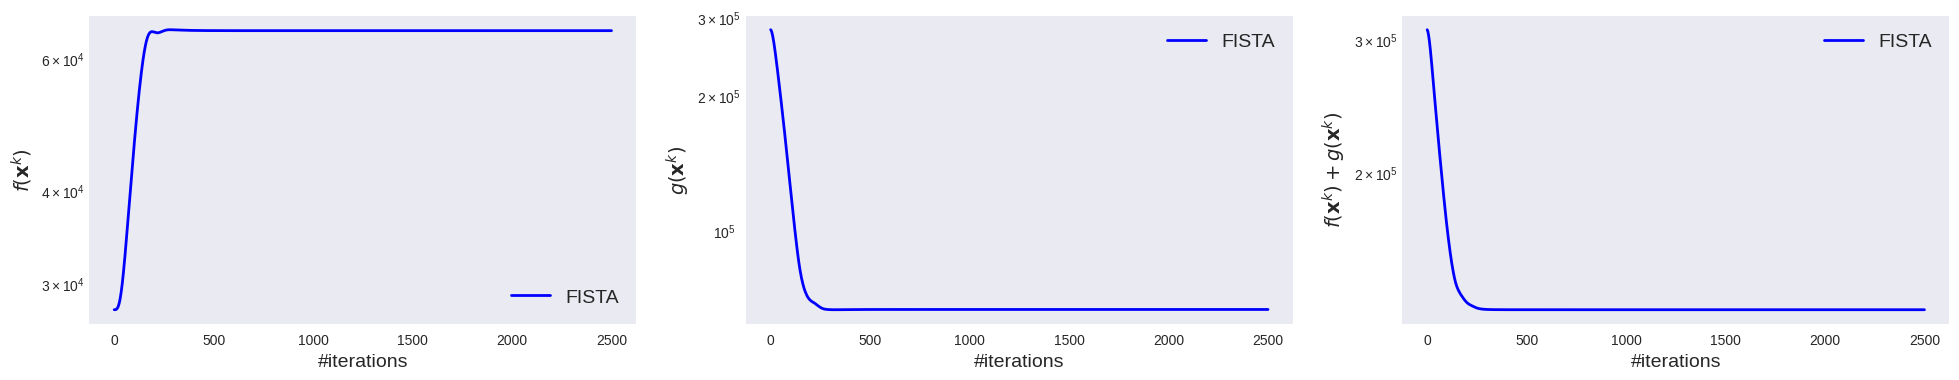

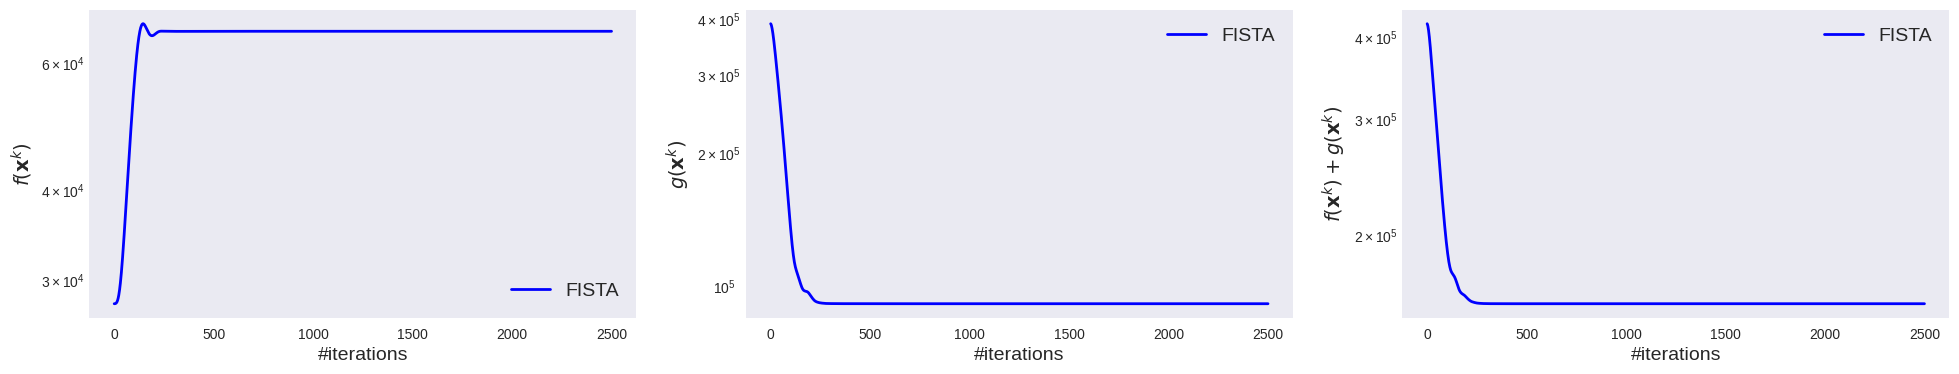

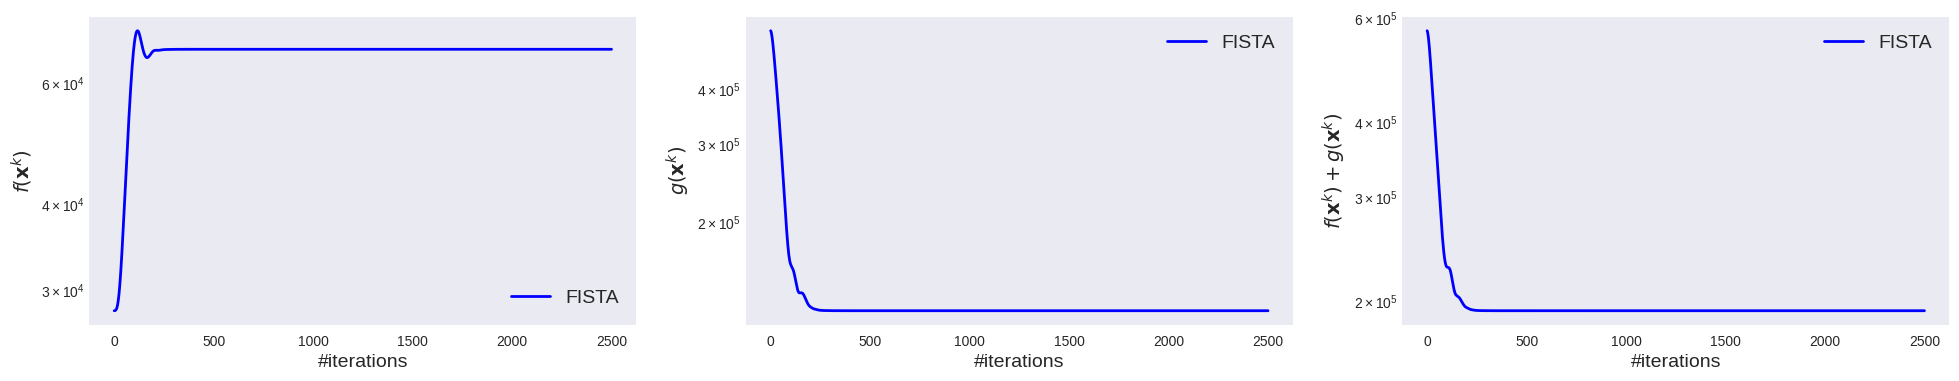

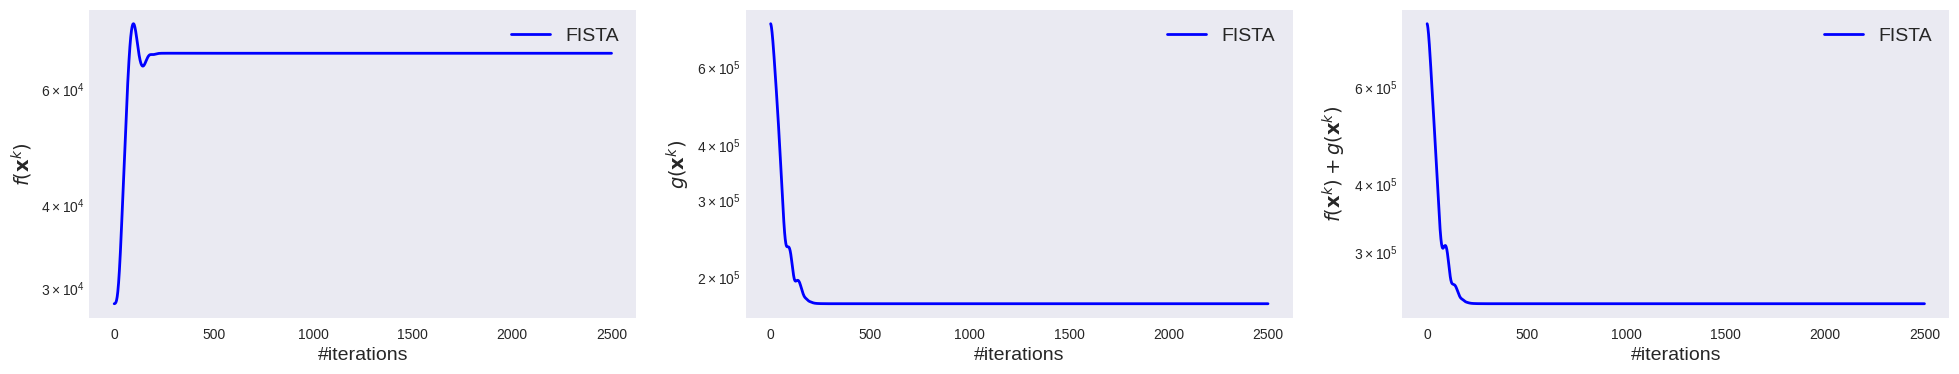

In [ ]:
def psnr(x, y):
    mse = np.mean((x - y)**2)
    return np.inf if mse == 0 else 20*np.log10(255.0/np.sqrt(mse))

lams = np.geomspace(0.02, 0.2, 8)
best = (-np.inf, None, None)

for lam in lams:
    alpha_hat = solve_composite(FISTA, composite_objective, lam, max_iterations=2500)
    img_hat = W_T(alpha_hat).reshape(image.shape)
    s = psnr(image.astype(float), img_hat.astype(float))
    if s > best[0]:
        best = (s, lam, img_hat)

print(f"Best PSNR={best[0]:.2f}dB at λ={best[1]:.3g}")
image_out = best[2]

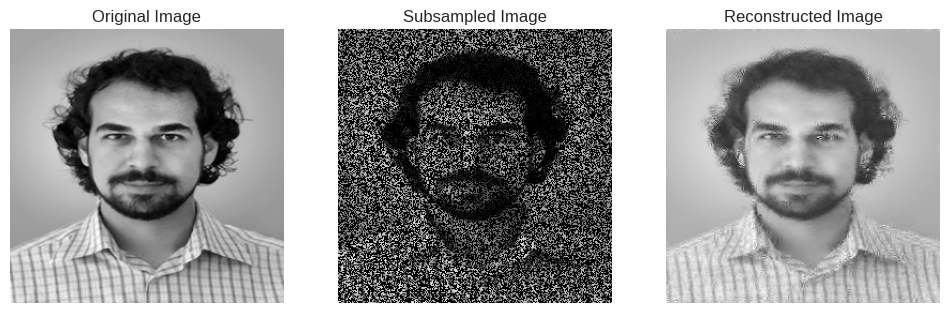

In [150]:
show(true = image, subsampled=subsampled, estimated=image_out)